In [22]:
# Notebook to study the gammas emmited from the 2nubb events
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.colors import LogNorm  # Import LogNorm for logarithmic color scale
from matplotlib.cm import get_cmap

# Create a sequential colormap
cmap = get_cmap('Spectral')  # You can choose any sequential colormap here

plt.rcParams['figure.facecolor'] = 'w'

# plt.rcParams["font.size"] = 15
# plt.rcParams["figure.figsize"] = 11,9

## Load in the files and print info

In [23]:
# Loading in the files
files = []

models = ["GS", "WVI"]

files.append("config/Next100_Tl208_Port1a_GS_slim_merged.h5") # GS model
files.append("config/Next100_Tl208_Port1a_WVI_slim_merged.h5") # LPR Port 1A event

print(files)

config_v = []
parts_v  = []
hits_v   = []
chits_v = []
 
for index, f in enumerate(files):
    # config_v.append(pd.read_hdf(f, 'MC/configuration'))
    parts_v .append(pd.read_hdf(f, 'MC/particles'))
    hits_v  .append(pd.read_hdf(f, 'MC/hits'))


['config/Next100_Tl208_Port1a_GS_slim_merged.h5', 'config/Next100_Tl208_Port1a_WVI_slim_merged.h5']


#### Apply containment and sum the hits in the active volume energy

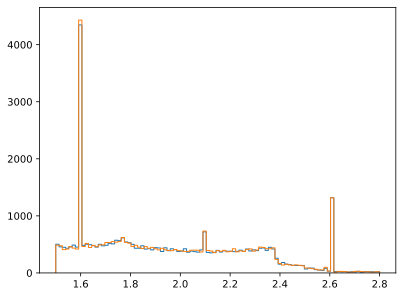

In [24]:
uncontained_hit_events_v = []
hits_contained_df_v = []
hit_tot_energy_v = []

plt.figure()

for m in range(len(hits_v)):

    # Get the hit tables and plot the total energy deposited in the TPC
    # uncontained_hit_events_v.append(hits_v[m][hits_v[m].label != "ACTIVE"].event_id.unique())

    # hits_contained_df_v.append(hits_v[m][~hits_v[m].event_id.isin(uncontained_hit_events_v[m]) ])
    hits_contained_df_v.append(hits_v[m])

    # Sum the energy of the hits and bin into a histogram
    # hit_tot_energy_v.append(hits_contained_df_v[m].groupby('event_id')['energy'].sum().reset_index(name='hit_tot_energy'))
    hit_tot_energy_v.append(hits_v[m].groupby('event_id')['energy'].sum().reset_index(name='hit_tot_energy'))

    # Also merge this event energy into the main dataframe
    # Merge the original DataFrame with the summed energy DataFrame based on 'event'
    # hits_contained_df_v[m] = pd.merge(hits_contained_df_v[m], hit_tot_energy_v[m], on='event_id')
    hits_contained_df_v[m] = pd.merge(hits_contained_df_v[m], hit_tot_energy_v[m], on='event_id')

    plt.hist(hit_tot_energy_v[m].hit_tot_energy, bins = np.linspace(1.5,2.8,100), histtype = "step");



Double escape events

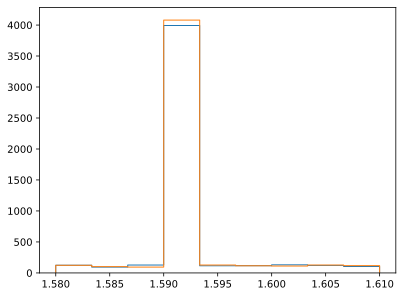

In [25]:
DE_hits_v = []
DE_event_ids_v = []
plt.figure()

for m in range(len(hits_contained_df_v)):
    # Get the DE peak events
    DE_hits_v.append(hits_contained_df_v[m][(hits_contained_df_v[m].hit_tot_energy > 1.58) & (hits_contained_df_v[m].hit_tot_energy < 1.61)  ])
    DE_event_ids_v.append(DE_hits_v[m].event_id)
    plt.hist(hit_tot_energy_v[m][hit_tot_energy_v[m].event_id.isin(DE_event_ids_v[m])].hit_tot_energy,histtype="step", bins = np.linspace(1.58, 1.61, 10));

### Photopeak events

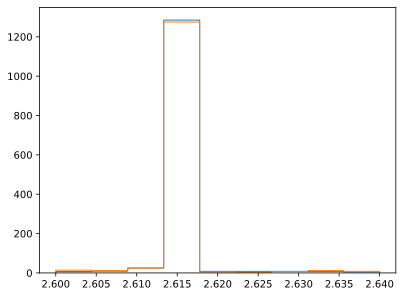

In [26]:
PP_hits_v = []
PP_event_ids_v = []
plt.figure()

for m in range(len(hits_contained_df_v)):
    # Get the DE peak events
    PP_hits_v.append(hits_contained_df_v[m][(hits_contained_df_v[m].hit_tot_energy > 2.6) & (hits_contained_df_v[m].hit_tot_energy < 2.64)  ])
    PP_event_ids_v.append(PP_hits_v[m].event_id)
    plt.hist(hit_tot_energy_v[m][hit_tot_energy_v[m].event_id.isin(PP_event_ids_v[m])].hit_tot_energy,histtype="step", bins = np.linspace(2.6, 2.64, 10));

### Get all the gammas in the event and the bremsstrahlung 
- Also applies conainment requirement of the gammas 
- Applies 2 cm cut to the bremstrahlung (this accounts for voxelation, but not necissarily the diffusion yet)

In [27]:
gammas_v = []
gammas_DE_v = []
gammas_PP_v = []
eBrem_DE_v = []
eBrem_PP_v = []


for m in range(len(parts_v)):

    # Plot the distance of the gammas and bin in a histogram
    gammas_v.append(parts_v[m][parts_v[m]["particle_name"] == "gamma" ])

    # Get all gammas that originate in the DE/PP peak
    gammas_DE_v.append(gammas_v[m][gammas_v[m].event_id.isin(DE_event_ids_v[m]) ])
    gammas_PP_v.append(gammas_v[m][gammas_v[m].event_id.isin(PP_event_ids_v[m]) ])

    # Create a table of bremstrahlung gammas
    eBrem_DE_v.append(gammas_DE_v[m][(gammas_DE_v[m]["creator_proc"] == "eBrem")])
    eBrem_PP_v.append(gammas_PP_v[m][(gammas_PP_v[m]["creator_proc"] == "eBrem")])


# Plot the bremstrahlung and their energy distribution in true 

In [28]:
n_photon_DE_v = []
n_photon_PP_v = []

for m in range(len(eBrem_DE_v)):

    n_photon_DE_temp = []
    n_photon_PP_temp = []

    # Start with DE events
    eventids = eBrem_DE_v[m].event_id.unique()
    for e in eventids:
        # The gammas dataframe is all gammas in the double escape peak
        event_DE = eBrem_DE_v[m][ eBrem_DE_v[m]["event_id"] == e]
        n_photon_DE_temp.append(len(event_DE))

    eventids = eBrem_PP_v[m].event_id.unique()
    for e in eventids:
        # The gammas dataframe is all gammas in the double escape peak
        event_PP = eBrem_PP_v[m][ eBrem_PP_v[m]["event_id"] == e]
        n_photon_PP_temp.append(len(event_PP))

    n_photon_DE_v.append(n_photon_DE_temp)
    n_photon_PP_v.append(n_photon_PP_temp)



Text(0.5, 1.0, 'Double Escape')

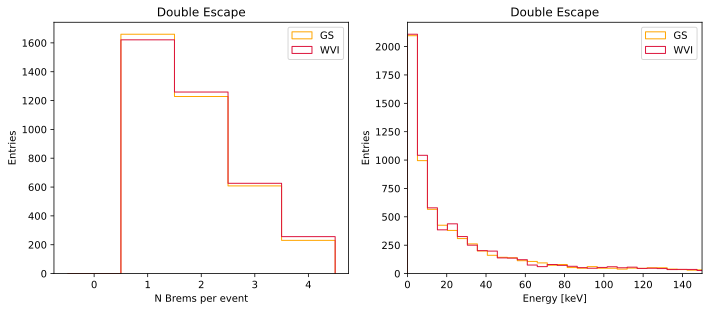

In [29]:
bin_edges = np.arange(-0.5, 5.5, 1)
bin_centers = np.arange(0, 5, 1)

plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Multiplicities
plt.subplot(2, 3, 1);
plt.hist(n_photon_DE_v[0], bins = bin_edges, histtype="step", label = "GS", color = "orange");
plt.hist(n_photon_DE_v[1], bins = bin_edges, histtype="step", label = "WVI", color = "crimson");
plt.xlabel("N Brems per event")
plt.ylabel("Entries")
plt.xticks(bin_centers) ;
plt.legend()
plt.title("Double Escape")

# Energies
plt.subplot(2, 3, 2);
plt.hist(eBrem_DE_v[0].kin_energy*1e3, bins=np.linspace(0, 300, 60), histtype="step", label=["GS"], color = "orange");
plt.hist(eBrem_DE_v[1].kin_energy*1e3, bins=np.linspace(0, 300, 60), histtype="step", label=["WVI"], color = "crimson");
plt.legend()
plt.xlabel("Energy [keV]")
plt.ylabel("Entries")
plt.xlim(0, 150)
plt.title("Double Escape")

Text(0.5, 1.0, 'Photopeak')

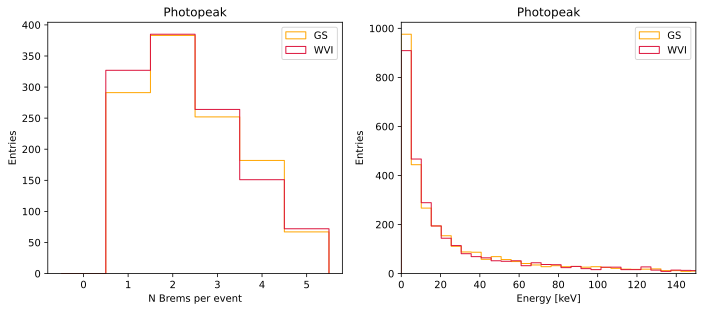

In [32]:
bin_edges = np.arange(-0.5, 6.5, 1)
bin_centers = np.arange(0, 6, 1)

plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Multiplicities
plt.subplot(2, 3, 1);
plt.hist(n_photon_PP_v[0], bins = bin_edges, histtype="step", label = "GS", color = "orange");
plt.hist(n_photon_PP_v[1], bins = bin_edges, histtype="step", label = "WVI", color = "crimson");
plt.xlabel("N Brems per event")
plt.ylabel("Entries")
plt.xticks(bin_centers) ;
plt.legend()
plt.title("Photopeak")

# Energies
plt.subplot(2, 3, 2);
plt.hist(eBrem_PP_v[0].kin_energy*1e3, bins=np.linspace(0, 300, 60), histtype="step", label=["GS"], color = "orange");
plt.hist(eBrem_PP_v[1].kin_energy*1e3, bins=np.linspace(0, 300, 60), histtype="step", label=["WVI"], color = "crimson");
plt.legend()
plt.xlabel("Energy [keV]")
plt.ylabel("Entries")
plt.xlim(0, 150)
plt.title("Photopeak")